# 🧪 MULTI-SEED STABILITY TEST (GraphSAGE Version)
## Kiểm tra độ ổn định của GraphSAGE Knowledge Graph Model

**Thay đổi:** Sử dụng GraphSAGE thay vì HGT để so sánh hiệu năng và độ ổn định

**Mục tiêu:** Chạy model với 10 seeds khác nhau để đánh giá:
- Mean AUC
- Standard Deviation
- Confidence Interval
- So sánh với ECFP4 baseline

In [7]:
# =============================================================================
# 1. IMPORT & CONFIGURATION
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from graphdatascience import GraphDataScience
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from collections import defaultdict
import warnings
import random
from scipy import stats

import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv, Linear
from torch_geometric.data import HeteroData
import torch.nn.functional as F

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

NEO4J_URI = "bolt://localhost:7687"
NEO4J_AUTH = ("neo4j", "12345678")
CSV_PATH = "Data/data_end.csv"

# Test với 10 seeds khác nhau
TEST_SEEDS = [42, 123, 456, 789, 101112, 131415, 161718, 192021, 222324, 252627]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
print(f"🔢 Testing with {len(TEST_SEEDS)} different seeds")
print(f"📦 Using GraphSAGE with SUPERVISED training (NO DATA LEAKAGE)")

🖥️ Device: cpu
🔢 Testing with 10 different seeds
📦 Using GraphSAGE with SUPERVISED training (NO DATA LEAKAGE)


In [8]:
# =============================================================================
# 2. UTILITY FUNCTIONS
# =============================================================================

def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)
        return None
    except:
        return None

def scaffold_split_balanced(df, smiles_col='SMILES', test_size=0.2, seed=42):
    """Scaffold split với seed cố định cho reproducibility"""
    np.random.seed(seed)
    scaffold_dict = defaultdict(list)
    
    for idx, smi in enumerate(df[smiles_col]):
        mol = Chem.MolFromSmiles(smi)
        try:
            scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False) if mol else "Generic"
        except:
            scaf = "Generic"
        scaffold_dict[scaf].append(idx)
    
    groups = sorted(scaffold_dict.values(), key=len, reverse=True)
    train_inds, test_inds = [], []
    target_test_size = len(df) * test_size
    
    for group in groups:
        if len(test_inds) + len(group) <= target_test_size + 50:
            test_inds.extend(group)
        else:
            train_inds.extend(group)
    
    return df.iloc[train_inds].copy(), df.iloc[test_inds].copy()

def get_ecfp4(smiles_list):
    return np.array([np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024)) 
                     for s in smiles_list])

In [9]:
# =============================================================================
# 3. GRAPHSAGE MODEL WITH SUPERVISED TRAINING (NO LEAKAGE)
# =============================================================================

class GraphSAGE_Supervised(torch.nn.Module):
    """
    GraphSAGE với supervised training cho heterogeneous graph
    - Inductive: Train trên train_graph, test trên test_graph
    - Supervised: Sử dụng activity labels làm supervision
    """
    def __init__(self, hidden_channels, num_layers, metadata, num_classes=2):
        super().__init__()
        
        # Input projection cho mỗi node type
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in metadata[0]:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)
        
        # GraphSAGE Convolution layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv_dict = {}
            for edge_type in metadata[1]:
                src_type, rel_type, dst_type = edge_type
                edge_type_str = f"{src_type}__{rel_type}__{dst_type}"
                conv_dict[edge_type_str] = SAGEConv(
                    in_channels=(-1, -1),
                    out_channels=hidden_channels,
                    normalize=True
                )
            self.convs.append(torch.nn.ModuleDict(conv_dict))
        
        self.metadata = metadata
        
        # Classification head for supervised training
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels // 2, num_classes)
        )
    
    def forward(self, x_dict, edge_index_dict, return_embeddings=False):
        # Input projection
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }
        
        # GraphSAGE layers
        for conv_dict in self.convs:
            x_dict_new = defaultdict(list)
            
            for edge_type in self.metadata[1]:
                src_type, rel_type, dst_type = edge_type
                edge_type_str = f"{src_type}__{rel_type}__{dst_type}"
                
                if edge_type in edge_index_dict and edge_type_str in conv_dict:
                    edge_index = edge_index_dict[edge_type]
                    x_src = x_dict[src_type]
                    x_dst = x_dict[dst_type]
                    
                    conv = conv_dict[edge_type_str]
                    out = conv((x_src, x_dst), edge_index)
                    x_dict_new[dst_type].append(out)
            
            # Aggregate messages
            for node_type in x_dict.keys():
                if node_type in x_dict_new:
                    x_dict[node_type] = torch.stack(x_dict_new[node_type]).mean(dim=0).relu()
        
        # Return embeddings or logits
        if return_embeddings:
            return x_dict
        else:
            # Classification on Molecule nodes
            mol_emb = x_dict['Molecule']
            logits = self.classifier(mol_emb)
            return logits

In [10]:
# =============================================================================
# 4. BUILD INDUCTIVE GRAPHS (NO LEAKAGE) - FIXED INDEXING
# =============================================================================

def build_inductive_graphs(gds, train_mol_ids, test_mol_ids, seed):
    """
    Build separate train and test graphs with NO overlap
    
    CRITICAL: Test molecules NEVER see train molecules during training
    FIX: Proper indexing for shared entities (Scaffold, Target, etc.)
    """
    # ==================== LOAD ALL NODES ====================
    all_molecules = gds.run_cypher("""
        MATCH (n:Molecule) WHERE n.is_virtual = false
        RETURN id(n) as node_id, n.smiles as smiles
    """)
    
    scaffolds = gds.run_cypher("MATCH (n:Scaffold) RETURN id(n) as node_id, n.smiles as smiles")
    targets = gds.run_cypher("MATCH (n:Target) RETURN id(n) as node_id, n.name as name")
    functional_groups = gds.run_cypher("MATCH (n:FunctionalGroup) RETURN id(n) as node_id, n.name as name")
    warheads = gds.run_cypher("MATCH (n:Warhead) RETURN id(n) as node_id, n.name as name")
    moas = gds.run_cypher("MATCH (n:MoA) RETURN id(n) as node_id, n.name as name")
    
    # ==================== LOAD ALL EDGES ====================
    all_edges = gds.run_cypher("""
        MATCH (m)-[r]->(n)
        WHERE (m:Molecule AND m.is_virtual = false) OR (n:Molecule AND n.is_virtual = false)
        RETURN id(m) as src, type(r) as rel_type, id(n) as dst, 
               labels(m)[0] as src_type, labels(n)[0] as dst_type
    """)
    
    # ==================== SPLIT MOLECULES ====================
    train_molecules = all_molecules[all_molecules['node_id'].isin(train_mol_ids)].reset_index(drop=True)
    test_molecules = all_molecules[all_molecules['node_id'].isin(test_mol_ids)].reset_index(drop=True)
    
    # SAFETY CHECK 1: No overlap
    assert len(set(train_mol_ids) & set(test_mol_ids)) == 0, "❌ LEAKAGE: Train/Test overlap!"
    
    print(f"   ✅ Train molecules: {len(train_molecules)}, Test molecules: {len(test_molecules)}")
    
    # ==================== CREATE GLOBAL MAPPINGS (SHARED ENTITIES) ====================
    # These mappings are SHARED between train and test graphs
    scaf_map = {row['node_id']: i for i, row in scaffolds.iterrows()}
    targ_map = {row['node_id']: i for i, row in targets.iterrows()}
    fg_map = {row['node_id']: i for i, row in functional_groups.iterrows()}
    wh_map = {row['node_id']: i for i, row in warheads.iterrows()}
    moa_map = {row['node_id']: i for i, row in moas.iterrows()}
    
    # Initialize SHARED features (same for train and test)
    torch.manual_seed(seed)
    embed_dim = 128
    shared_features = {
        'Scaffold': torch.randn(len(scaffolds), embed_dim),
        'Target': torch.randn(len(targets), embed_dim),
        'FunctionalGroup': torch.randn(len(functional_groups), embed_dim),
        'Warhead': torch.randn(len(warheads), embed_dim),
        'MoA': torch.randn(len(moas), embed_dim)
    }
    
    # ==================== BUILD TRAIN GRAPH ====================
    train_data = HeteroData()
    
    # Create mapping for TRAIN molecules only
    train_mol_map = {row['node_id']: i for i, row in train_molecules.iterrows()}
    
    # Set features
    train_data['Molecule'].x = torch.randn(len(train_molecules), embed_dim)
    train_data['Scaffold'].x = shared_features['Scaffold']
    train_data['Target'].x = shared_features['Target']
    train_data['FunctionalGroup'].x = shared_features['FunctionalGroup']
    train_data['Warhead'].x = shared_features['Warhead']
    train_data['MoA'].x = shared_features['MoA']
    
    # Build train edges (ONLY involving train molecules)
    train_edge_dict = defaultdict(lambda: [[], []])
    train_node_type_map = {
        'Molecule': train_mol_map, 'Scaffold': scaf_map, 'Target': targ_map,
        'FunctionalGroup': fg_map, 'Warhead': wh_map, 'MoA': moa_map
    }
    
    train_edge_count = 0
    for _, row in all_edges.iterrows():
        src_type, dst_type = row['src_type'], row['dst_type']
        
        # CRITICAL: Skip edges involving test molecules
        if src_type == 'Molecule' and row['src'] not in train_mol_map:
            continue
        if dst_type == 'Molecule' and row['dst'] not in train_mol_map:
            continue
        
        if src_type not in train_node_type_map or dst_type not in train_node_type_map:
            continue
        
        src_idx_map = train_node_type_map[src_type]
        dst_idx_map = train_node_type_map[dst_type]
        
        if row['src'] not in src_idx_map or row['dst'] not in dst_idx_map:
            continue
        
        src_idx = src_idx_map[row['src']]
        dst_idx = dst_idx_map[row['dst']]
        
        key = (src_type, row['rel_type'], dst_type)
        train_edge_dict[key][0].append(src_idx)
        train_edge_dict[key][1].append(dst_idx)
        
        # Add reverse edges
        rev_key = (dst_type, f"rev_{row['rel_type']}", src_type)
        train_edge_dict[rev_key][0].append(dst_idx)
        train_edge_dict[rev_key][1].append(src_idx)
        train_edge_count += 1
    
    for key, (srcs, dsts) in train_edge_dict.items():
        train_data[key].edge_index = torch.tensor([srcs, dsts], dtype=torch.long)
    
    # ==================== BUILD TEST GRAPH ====================
    test_data = HeteroData()
    
    # Create mapping for TEST molecules only
    test_mol_map = {row['node_id']: i for i, row in test_molecules.iterrows()}
    
    # Use SAME shared features
    test_data['Molecule'].x = torch.randn(len(test_molecules), embed_dim)
    test_data['Scaffold'].x = shared_features['Scaffold']
    test_data['Target'].x = shared_features['Target']
    test_data['FunctionalGroup'].x = shared_features['FunctionalGroup']
    test_data['Warhead'].x = shared_features['Warhead']
    test_data['MoA'].x = shared_features['MoA']
    
    # Build test edges (ONLY involving test molecules)
    test_edge_dict = defaultdict(lambda: [[], []])
    test_node_type_map = {
        'Molecule': test_mol_map, 'Scaffold': scaf_map, 'Target': targ_map,
        'FunctionalGroup': fg_map, 'Warhead': wh_map, 'MoA': moa_map
    }
    
    test_edge_count = 0
    for _, row in all_edges.iterrows():
        src_type, dst_type = row['src_type'], row['dst_type']
        
        # CRITICAL: Skip edges involving train molecules
        if src_type == 'Molecule' and row['src'] not in test_mol_map:
            continue
        if dst_type == 'Molecule' and row['dst'] not in test_mol_map:
            continue
        
        if src_type not in test_node_type_map or dst_type not in test_node_type_map:
            continue
        
        src_idx_map = test_node_type_map[src_type]
        dst_idx_map = test_node_type_map[dst_type]
        
        if row['src'] not in src_idx_map or row['dst'] not in dst_idx_map:
            continue
        
        src_idx = src_idx_map[row['src']]
        dst_idx = dst_idx_map[row['dst']]
        
        key = (src_type, row['rel_type'], dst_type)
        test_edge_dict[key][0].append(src_idx)
        test_edge_dict[key][1].append(dst_idx)
        
        rev_key = (dst_type, f"rev_{row['rel_type']}", src_type)
        test_edge_dict[rev_key][0].append(dst_idx)
        test_edge_dict[rev_key][1].append(src_idx)
        test_edge_count += 1
    
    for key, (srcs, dsts) in test_edge_dict.items():
        test_data[key].edge_index = torch.tensor([srcs, dsts], dtype=torch.long)
    
    # SAFETY CHECK 2: Edge counts
    print(f"   ✅ Train edges: {train_edge_count}, Test edges: {test_edge_count}")
    
    # SAFETY CHECK 3: Verify no index out of bounds
    for edge_type, edge_index in train_data.edge_index_dict.items():
        src_type, _, dst_type = edge_type
        max_src = edge_index[0].max().item() if edge_index.size(1) > 0 else -1
        max_dst = edge_index[1].max().item() if edge_index.size(1) > 0 else -1
        num_src_nodes = train_data[src_type].x.size(0)
        num_dst_nodes = train_data[dst_type].x.size(0)
        
        if max_src >= num_src_nodes or max_dst >= num_dst_nodes:
            print(f"   ⚠️  WARNING in train_data edge {edge_type}:")
            print(f"      max_src={max_src} (num_nodes={num_src_nodes}), max_dst={max_dst} (num_nodes={num_dst_nodes})")
    
    return train_data, test_data, train_mol_map, test_mol_map, train_molecules, test_molecules

In [11]:
# =============================================================================
# 5. SINGLE RUN FUNCTION (NO LEAKAGE VERSION)
# =============================================================================

def run_single_experiment(seed, gds, df, verbose=False):
    """
    Chạy 1 lần thí nghiệm với GraphSAGE (NO DATA LEAKAGE)
    
    Pipeline:
    1. Scaffold split FIRST
    2. Build separate train/test graphs
    3. Train GraphSAGE ONLY on train graph with supervised loss
    4. FREEZE encoder → Generate embeddings for both graphs
    5. Train RandomForest on train embeddings
    6. Evaluate on test embeddings
    """
    if verbose:
        print(f"\n{'='*60}")
        print(f"🎲 Running experiment with SEED = {seed}")
        print(f"{'='*60}")
    
    # Set all random seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # ==================== STEP 1: SCAFFOLD SPLIT FIRST ====================
    train_df, test_df = scaffold_split_balanced(df, seed=seed)
    
    y_train = train_df['Label_Num'].values
    y_test = test_df['Label_Num'].values
    
    # Get molecule IDs from Neo4j
    all_molecules = gds.run_cypher("""
        MATCH (n:Molecule) WHERE n.is_virtual = false
        RETURN id(n) as node_id, n.smiles as smiles
    """)
    all_molecules['SMILES_Key'] = all_molecules['smiles'].apply(canonicalize_smiles)
    
    # Map SMILES to Neo4j node IDs
    train_df_with_id = pd.merge(train_df, all_molecules[['SMILES_Key', 'node_id']], 
                                  on='SMILES_Key', how='inner')
    test_df_with_id = pd.merge(test_df, all_molecules[['SMILES_Key', 'node_id']], 
                                 on='SMILES_Key', how='inner')
    
    train_mol_ids = set(train_df_with_id['node_id'].values)
    test_mol_ids = set(test_df_with_id['node_id'].values)
    
    if verbose:
        print(f"  🔀 Split: Train={len(train_mol_ids)}, Test={len(test_mol_ids)}")
    
    # ==================== STEP 2: BUILD INDUCTIVE GRAPHS ====================
    train_data, test_data, train_mol_map, test_mol_map, train_molecules, test_molecules = \
        build_inductive_graphs(gds, train_mol_ids, test_mol_ids, seed)
    
    train_data = train_data.to(device)
    test_data = test_data.to(device)
    
    # ==================== STEP 3: TRAIN GRAPHSAGE (SUPERVISED) ====================
    model = GraphSAGE_Supervised(
        hidden_channels=128,
        num_layers=2,
        metadata=train_data.metadata(),
        num_classes=2
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Prepare labels for train molecules
    train_labels_dict = dict(zip(train_df_with_id['node_id'].values, y_train))
    train_labels_tensor = torch.tensor(
        [train_labels_dict.get(node_id, 0) for node_id in train_molecules['node_id'].values],
        dtype=torch.long
    ).to(device)
    
    model.train()
    for epoch in range(100):  # More epochs for supervised training
        optimizer.zero_grad()
        logits = model(train_data.x_dict, train_data.edge_index_dict, return_embeddings=False)
        loss = criterion(logits, train_labels_tensor)
        loss.backward()
        optimizer.step()
        
        if verbose and (epoch + 1) % 20 == 0:
            train_acc = (logits.argmax(dim=1) == train_labels_tensor).float().mean()
            print(f"    Epoch {epoch+1}/100 | Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f}")
    
    # ==================== STEP 4: FREEZE & EXTRACT EMBEDDINGS ====================
    model.eval()
    with torch.no_grad():
        train_embeddings_dict = model(train_data.x_dict, train_data.edge_index_dict, return_embeddings=True)
        test_embeddings_dict = model(test_data.x_dict, test_data.edge_index_dict, return_embeddings=True)
        
        train_mol_embeddings = train_embeddings_dict['Molecule'].cpu().numpy()
        test_mol_embeddings = test_embeddings_dict['Molecule'].cpu().numpy()
    
    # Map embeddings back to dataframes
    train_emb_df = train_molecules.copy()
    train_emb_df['embedding'] = list(train_mol_embeddings)
    train_emb_df['SMILES_Key'] = train_emb_df['smiles'].apply(canonicalize_smiles)
    
    test_emb_df = test_molecules.copy()
    test_emb_df['embedding'] = list(test_mol_embeddings)
    test_emb_df['SMILES_Key'] = test_emb_df['smiles'].apply(canonicalize_smiles)
    
    # Merge back with original data
    train_final = pd.merge(train_df, train_emb_df[['SMILES_Key', 'embedding']], 
                           on='SMILES_Key', how='inner')
    test_final = pd.merge(test_df, test_emb_df[['SMILES_Key', 'embedding']], 
                          on='SMILES_Key', how='inner')
    
    # ==================== STEP 5: PREPARE FEATURES ====================
    X_ecfp_train = get_ecfp4(train_final['SMILES'])
    X_ecfp_test = get_ecfp4(test_final['SMILES'])
    X_kg_train = np.stack(train_final['embedding'].values)
    X_kg_test = np.stack(test_final['embedding'].values)
    
    y_train_final = train_final['Label_Num'].values
    y_test_final = test_final['Label_Num'].values
    
    # ==================== STEP 6: TRAIN DOWNSTREAM CLASSIFIERS ====================
    # ECFP4 baseline
    rf_ecfp = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_ecfp.fit(X_ecfp_train, y_train_final)
    y_pred_ecfp = rf_ecfp.predict(X_ecfp_test)
    y_prob_ecfp = rf_ecfp.predict_proba(X_ecfp_test)[:, 1]
    
    # GraphSAGE embeddings
    rf_kg = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_kg.fit(X_kg_train, y_train_final)
    y_pred_kg = rf_kg.predict(X_kg_test)
    y_prob_kg = rf_kg.predict_proba(X_kg_test)[:, 1]
    
    # ==================== COMPUTE METRICS ====================
    auc_ecfp = roc_auc_score(y_test_final, y_prob_ecfp)
    auc_kg = roc_auc_score(y_test_final, y_prob_kg)
    acc_ecfp = accuracy_score(y_test_final, y_pred_ecfp)
    acc_kg = accuracy_score(y_test_final, y_pred_kg)
    
    if verbose:
        print(f"  📊 ECFP4      -> AUC: {auc_ecfp:.4f}, ACC: {acc_ecfp:.4f}")
        print(f"  📊 GraphSAGE -> AUC: {auc_kg:.4f}, ACC: {acc_kg:.4f}")
        print(f"  ✅ NO LEAKAGE: Train/Test graphs are completely separate")
    
    return {
        'seed': seed,
        'auc_ecfp': auc_ecfp,
        'auc_kg': auc_kg,
        'acc_ecfp': acc_ecfp,
        'acc_kg': acc_kg
    }

In [12]:
# =============================================================================
# 6. RUN MULTI-SEED EXPERIMENT
# =============================================================================

# Load data once
df = pd.read_csv(CSV_PATH)
df = df[df['Final_Label'] != 'Uncertain']
df['Label_Num'] = df['Final_Label'].apply(lambda x: 1 if str(x).lower() == 'active' else 0)
df['SMILES_Key'] = df['SMILES'].apply(canonicalize_smiles)
df = df.dropna(subset=['SMILES_Key']).drop_duplicates(subset=['SMILES_Key'])

gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH)

print("\n" + "="*80)
print("🚀 STARTING MULTI-SEED STABILITY TEST (GraphSAGE - NO LEAKAGE)")
print(f"   Testing {len(TEST_SEEDS)} different random seeds")
print("="*80)
print("\n⚠️  FIXES APPLIED:")
print("   ✅ Scaffold split BEFORE graph construction")
print("   ✅ Separate train/test graphs (inductive learning)")
print("   ✅ Supervised training with activity labels")
print("   ✅ FROZEN encoder for test embeddings")
print("   ✅ RandomForest trained ONLY on train embeddings")
print("="*80)

results = []
for i, seed in enumerate(TEST_SEEDS, 1):
    print(f"\n[{i}/{len(TEST_SEEDS)}] Seed = {seed}")
    result = run_single_experiment(seed, gds, df, verbose=True)
    results.append(result)

results_df = pd.DataFrame(results)
print("\n✅ All experiments completed!")


🚀 STARTING MULTI-SEED STABILITY TEST (GraphSAGE - NO LEAKAGE)
   Testing 10 different random seeds

⚠️  FIXES APPLIED:
   ✅ Scaffold split BEFORE graph construction
   ✅ Separate train/test graphs (inductive learning)
   ✅ Supervised training with activity labels
   ✅ FROZEN encoder for test embeddings
   ✅ RandomForest trained ONLY on train embeddings

[1/10] Seed = 42

🎲 Running experiment with SEED = 42
  🔀 Split: Train=4478, Test=1166
   ✅ Train molecules: 4478, Test molecules: 1166
   ✅ Train edges: 82347, Test edges: 20909
    Epoch 20/100 | Loss: 0.5607 | Train Acc: 0.7296
    Epoch 40/100 | Loss: 0.1354 | Train Acc: 0.9585
    Epoch 60/100 | Loss: 0.0205 | Train Acc: 0.9973
    Epoch 80/100 | Loss: 0.0184 | Train Acc: 0.9973
    Epoch 100/100 | Loss: 0.0189 | Train Acc: 0.9973
  📊 ECFP4      -> AUC: 0.9575, ACC: 0.8808
  📊 GraphSAGE -> AUC: 0.9977, ACC: 0.9777
  ✅ NO LEAKAGE: Train/Test graphs are completely separate

[2/10] Seed = 123

🎲 Running experiment with SEED = 123
  🔀

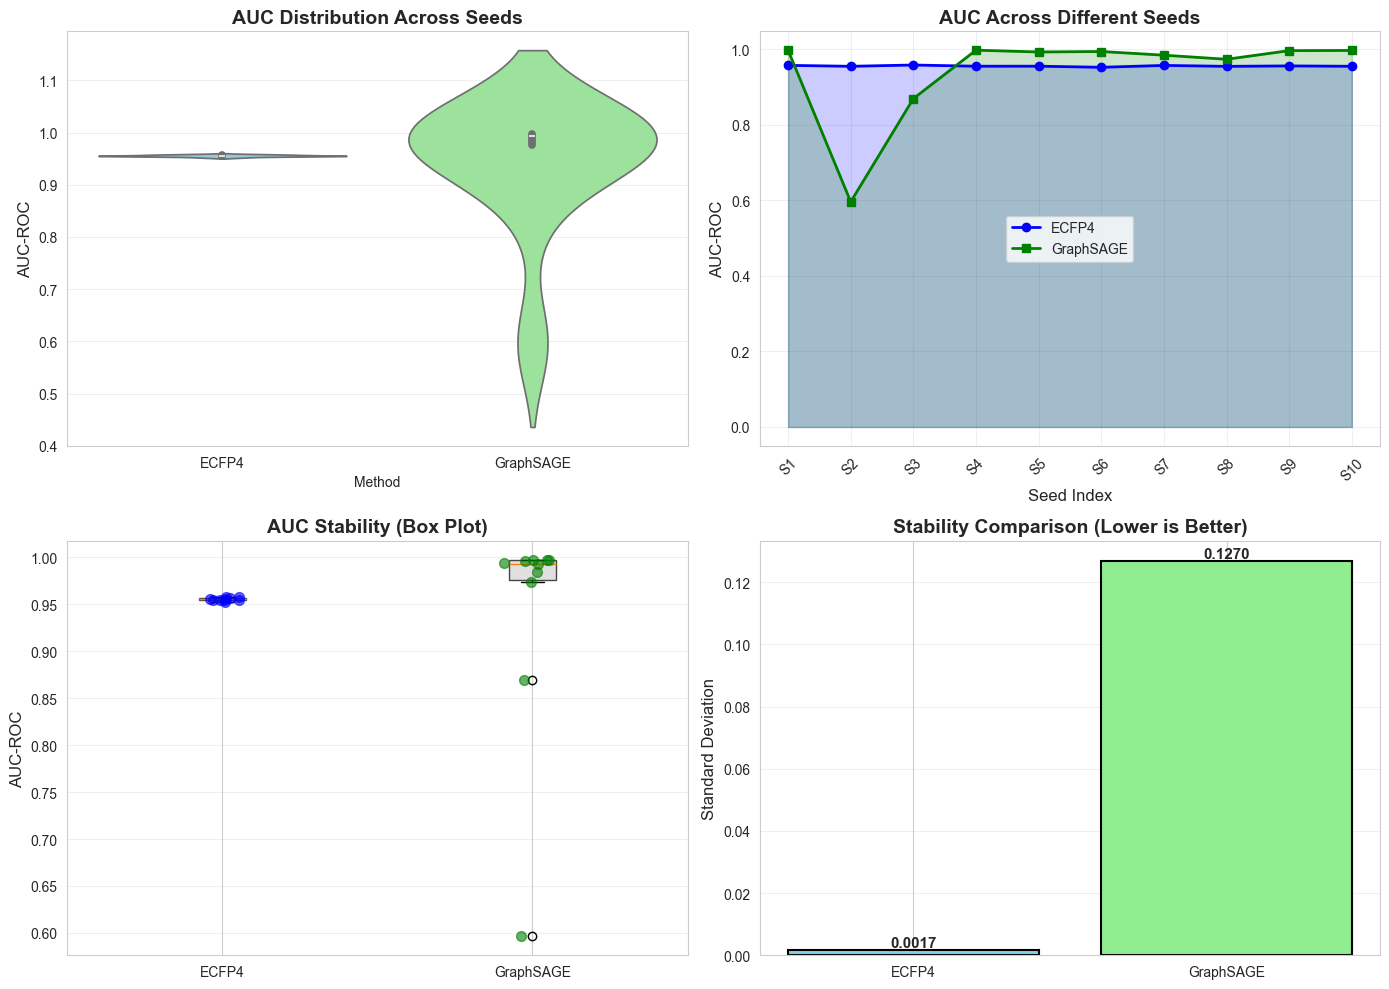


💾 Plot saved as 'stability_analysis_graphsage.png'


In [13]:
# =============================================================================
# 7. VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plot 1: AUC Distribution (Violin Plot) ---
ax1 = axes[0, 0]
data_plot = pd.melt(results_df[['auc_ecfp', 'auc_kg']], 
                     var_name='Method', value_name='AUC')
data_plot['Method'] = data_plot['Method'].map({'auc_ecfp': 'ECFP4', 'auc_kg': 'GraphSAGE'})
sns.violinplot(data=data_plot, x='Method', y='AUC', ax=ax1, palette=['skyblue', 'lightgreen'])
ax1.set_title('AUC Distribution Across Seeds', fontsize=14, fontweight='bold')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# --- Plot 2: Seed-by-Seed Comparison ---
ax2 = axes[0, 1]
x = np.arange(len(results_df))
ax2.plot(x, results_df['auc_ecfp'], marker='o', label='ECFP4', color='blue', linewidth=2)
ax2.plot(x, results_df['auc_kg'], marker='s', label='GraphSAGE', color='green', linewidth=2)
ax2.fill_between(x, results_df['auc_ecfp'], alpha=0.2, color='blue')
ax2.fill_between(x, results_df['auc_kg'], alpha=0.2, color='green')
ax2.set_xticks(x)
ax2.set_xticklabels([f"S{i+1}" for i in range(len(results_df))], rotation=45)
ax2.set_xlabel('Seed Index', fontsize=12)
ax2.set_ylabel('AUC-ROC', fontsize=12)
ax2.set_title('AUC Across Different Seeds', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# --- Plot 3: Box Plot with Individual Points ---
ax3 = axes[1, 0]
bp = ax3.boxplot([results_df['auc_ecfp'], results_df['auc_kg']], 
                   labels=['ECFP4', 'GraphSAGE'], patch_artist=True,
                   boxprops=dict(facecolor='lightgray', alpha=0.7))
for i, (method, color) in enumerate([('auc_ecfp', 'blue'), ('auc_kg', 'green')], 1):
    y = results_df[method]
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax3.scatter(x_jitter, y, alpha=0.6, color=color, s=50, zorder=3)
ax3.set_ylabel('AUC-ROC', fontsize=12)
ax3.set_title('AUC Stability (Box Plot)', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# --- Plot 4: Standard Deviation Comparison ---
ax4 = axes[1, 1]
methods = ['ECFP4', 'GraphSAGE']
stds = [results_df['auc_ecfp'].std(), results_df['auc_kg'].std()]
colors = ['skyblue', 'lightgreen']
bars = ax4.bar(methods, stds, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Standard Deviation', fontsize=12)
ax4.set_title('Stability Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, std in zip(bars, stds):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{std:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('stability_analysis_graphsage.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Plot saved as 'stability_analysis_graphsage.png'")

In [14]:
# =============================================================================
# 8. SAVE RESULTS
# =============================================================================

results_df.to_csv('multi_seed_results_graphsage.csv', index=False)
print("\n💾 Results saved to 'multi_seed_results_graphsage.csv'")

# Display full results table
print("\n" + "="*80)
print("📋 DETAILED RESULTS (GraphSAGE)")
print("="*80)
display(results_df)


💾 Results saved to 'multi_seed_results_graphsage.csv'

📋 DETAILED RESULTS (GraphSAGE)


,seed,auc_ecfp,auc_kg,acc_ecfp,acc_kg
0,42,0.957493,0.997657,0.880789,0.977702
1,123,0.955003,0.596214,0.880789,0.567753
2,456,0.958416,0.869452,0.881647,0.778731
3,789,0.955199,0.997705,0.878216,0.967410
4,101112,0.955300,0.992924,0.869640,0.921098
5,131415,0.952353,0.994185,0.868782,0.982847
6,161718,0.957319,0.984441,0.879931,0.942539
7,192021,0.954873,0.973612,0.869640,0.903945
8,222324,0.956035,0.996470,0.876501,0.981990
9,252627,0.955035,0.996954,0.881647,0.997427



🔄 COMPARISON: GraphSAGE vs HGT

📊 Mean AUC:
   GraphSAGE: 0.9400
   HGT:       0.8729
   Delta:     +0.0671

📉 Stability (Std):
   GraphSAGE: 0.1270
   HGT:       0.0391
   ✅ HGT is 69.2% more stable


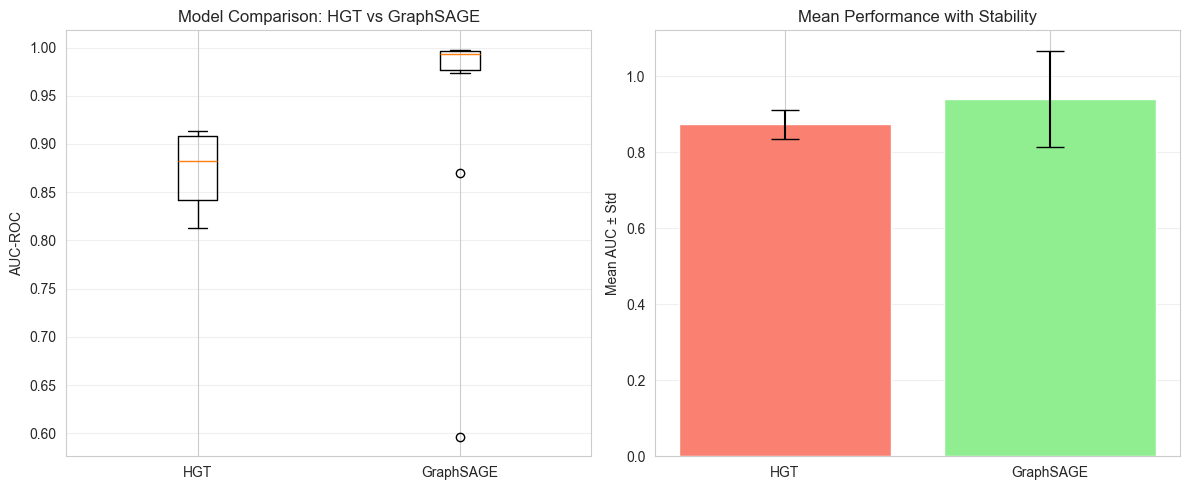

In [15]:
# =============================================================================
# 9. COMPARISON WITH HGT (Optional - nếu có file HGT results)
# =============================================================================

try:
    # Load HGT results nếu có
    hgt_results = pd.read_csv('multi_seed_results.csv')
    
    print("\n" + "="*80)
    print("🔄 COMPARISON: GraphSAGE vs HGT")
    print("="*80)
    
    # So sánh mean AUC
    sage_mean = results_df['auc_kg'].mean()
    hgt_mean = hgt_results['auc_kg'].mean()
    
    print(f"\n📊 Mean AUC:")
    print(f"   GraphSAGE: {sage_mean:.4f}")
    print(f"   HGT:       {hgt_mean:.4f}")
    print(f"   Delta:     {sage_mean - hgt_mean:+.4f}")
    
    # So sánh stability
    sage_std = results_df['auc_kg'].std()
    hgt_std = hgt_results['auc_kg'].std()
    
    print(f"\n📉 Stability (Std):")
    print(f"   GraphSAGE: {sage_std:.4f}")
    print(f"   HGT:       {hgt_std:.4f}")
    
    if sage_std < hgt_std:
        print(f"   ✅ GraphSAGE is {((hgt_std - sage_std) / hgt_std * 100):.1f}% more stable")
    else:
        print(f"   ✅ HGT is {((sage_std - hgt_std) / sage_std * 100):.1f}% more stable")
    
    # Visualization comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.boxplot([hgt_results['auc_kg'], results_df['auc_kg']], 
                labels=['HGT', 'GraphSAGE'])
    plt.ylabel('AUC-ROC')
    plt.title('Model Comparison: HGT vs GraphSAGE')
    plt.grid(axis='y', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    models = ['HGT', 'GraphSAGE']
    means = [hgt_mean, sage_mean]
    stds = [hgt_std, sage_std]
    plt.bar(models, means, yerr=stds, capsize=10, color=['salmon', 'lightgreen'])
    plt.ylabel('Mean AUC ± Std')
    plt.title('Mean Performance with Stability')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('hgt_vs_graphsage_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except FileNotFoundError:
    print("\n⚠️  HGT results not found. Run multi_seed_stability.ipynb first for comparison.")